# GNN 유형
1. Node Classification
2. Graph Classification
3. Link Prediction

## Library

In [29]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

## Dataset

In [30]:
# Create a synthetic graph dataset
def create_synthetic_graph():
    G = nx.karate_club_graph()
    edge_index = torch.tensor(list(G.edges)).t().contiguous()
    x = torch.eye(len(G.nodes))
    y = torch.tensor(
        [G.nodes[i]['club'] == 'Mr. Hi' for i in range(len(G.nodes))], 
        dtype=torch.long
    )
    data = Data(x=x, edge_index=edge_index, y=y)
    return data

data = create_synthetic_graph()

In [31]:
data.x

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [32]:
data.y

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## EDA

In [33]:
# EDA Functions
def plot_graph(data):
    G = nx.Graph()
    G.add_edges_from(data.edge_index.t().tolist())
    node_colors = ['red' if y else 'blue' for y in data.y.tolist()]
    plt.figure(figsize=(8, 6))
    nx.draw(
        G, 
        with_labels=True, 
        node_color=node_colors, 
        node_size=500, 
        edge_color='gray'
    )
    plt.title("Graph Visualization")
    plt.show()

def graph_statistics(data):
    G = nx.Graph()
    G.add_edges_from(data.edge_index.t().tolist())
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    avg_degree = sum(dict(G.degree()).values()) / num_nodes
    print(f"Number of nodes: {num_nodes}")
    print(f"Number of edges: {num_edges}")
    print(f"Average node degree: {avg_degree:.2f}")

def class_distribution(data):
    unique, counts = np.unique(data.y.numpy(), return_counts=True)
    plt.bar(unique, counts, color=['blue', 'red'])
    plt.xticks(unique, ['Class 0', 'Class 1'])
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.title("Class Distribution")
    plt.show()
    print(f"Class distribution: {dict(zip(unique, counts))}")

In [34]:
graph_statistics(data)

Number of nodes: 34
Number of edges: 78
Average node degree: 4.59


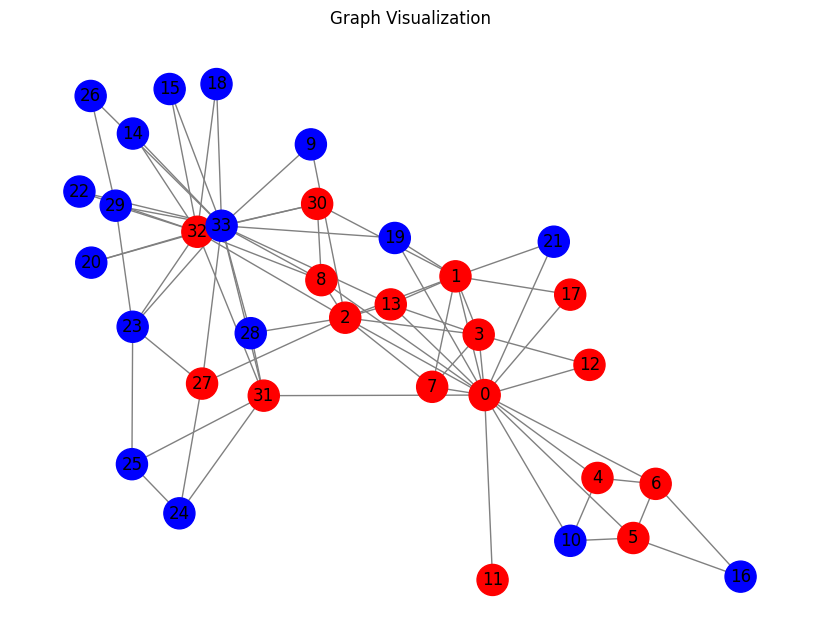

In [35]:
plot_graph(data)

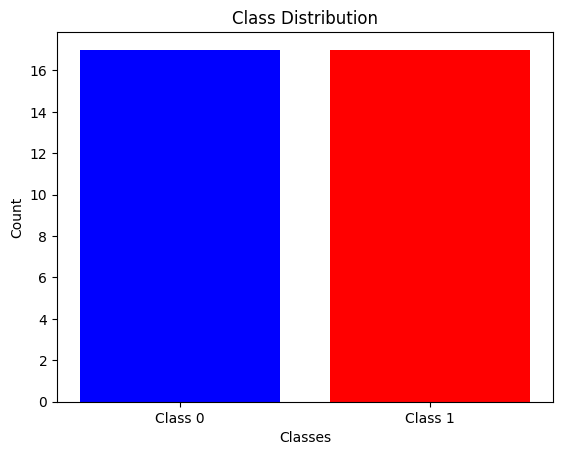

Class distribution: {0: 17, 1: 17}


In [36]:
class_distribution(data)

## GCN Model

In [37]:
# Define GCN Model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Train function
def train(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Test function
def test(model, data):
    model.eval()
    out = model(data).argmax(dim=1)
    acc = (out == data.y).sum().item() / len(data.y)
    return acc

## Node Classification

In [38]:
# Node Classification
gcn_node = GCN(data.num_features, 16, 2)
optimizer = torch.optim.Adam(
    gcn_node.parameters(), 
    lr=0.01, 
    weight_decay=5e-4
)

for epoch in range(100):
    loss = train(gcn_node, data, optimizer)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, | Loss: {loss:.4f}')
print(f'Node Classification Accuracy: {test(gcn_node, data):.4f}')

Epoch 0, | Loss: 0.6898
Epoch 10, | Loss: 0.4969
Epoch 20, | Loss: 0.3933
Epoch 30, | Loss: 0.1788
Epoch 40, | Loss: 0.1027
Epoch 50, | Loss: 0.0782
Epoch 60, | Loss: 0.0541
Epoch 70, | Loss: 0.0366
Epoch 80, | Loss: 0.0260
Epoch 90, | Loss: 0.0433
Node Classification Accuracy: 1.0000


## Graph Classification

In [39]:
graphs = [create_synthetic_graph() for _ in range(100)]
dataloader = DataLoader(
    graphs, 
    batch_size=32, 
    shuffle=True
)

gcn_graph = GCN(data.num_features, 16, 2)
optimizer = torch.optim.Adam(
    gcn_graph.parameters(), 
    lr=0.01, 
    weight_decay=5e-4
)

def train_graph():
    gcn_graph.train()
    total_loss = 0
    for data in dataloader:
        optimizer.zero_grad()
        out = gcn_graph(data)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

for epoch in range(100):
    loss = train_graph()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, | Loss: {loss:.4f}')
print(f'Graph Classification Accuracy: {test(gcn_graph, data):.4f}')

/home/kubwa/anaconda3/envs/gnn/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 0, | Loss: 0.6848
Epoch 10, | Loss: 0.0885
Epoch 20, | Loss: 0.0306
Epoch 30, | Loss: 0.0228
Epoch 40, | Loss: 0.0136
Epoch 50, | Loss: 0.0137
Epoch 60, | Loss: 0.0117
Epoch 70, | Loss: 0.0126
Epoch 80, | Loss: 0.0133
Epoch 90, | Loss: 0.0101
Graph Classification Accuracy: 1.0000


## Link Prediction

In [49]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv

# Define GCN Model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

    def forward(self, data):
        x = F.relu(self.conv1(data.x, data.edge_index))
        x = self.conv2(x, data.edge_index)
        return x

In [50]:
def decode_link(z, edge_index):
    return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)

# Train function
def train(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    z = model(data)
    pos_edge_index = data.edge_index
    neg_edge_index = torch.randint(0, data.num_nodes, pos_edge_index.shape, dtype=torch.long)
    
    pos_pred = decode_link(z, pos_edge_index)
    neg_pred = decode_link(z, neg_edge_index)
    loss = F.binary_cross_entropy_with_logits(pos_pred, torch.ones_like(pos_pred)) + \
           F.binary_cross_entropy_with_logits(neg_pred, torch.zeros_like(neg_pred))
    loss.backward()
    optimizer.step()
    return loss.item()

def test(model, data):
    model.eval()
    z = model(data)
    pos_edge_index = data.edge_index
    neg_edge_index = torch.randint(0, data.num_nodes, pos_edge_index.shape, dtype=torch.long)
    
    pos_pred = decode_link(z, pos_edge_index).sigmoid()
    neg_pred = decode_link(z, neg_edge_index).sigmoid()
    acc = ((pos_pred > 0.5).sum() + (neg_pred <= 0.5).sum()).item() / (pos_pred.size(0) + neg_pred.size(0))
    return acc

In [51]:
# Link Prediction
gcn_link = GCN(data.num_features, 16)
optimizer = torch.optim.Adam(gcn_link.parameters(), lr=0.01, weight_decay=5e-4)
for epoch in range(100):
    loss = train(gcn_link, data, optimizer)
    if epoch % 10 == 0:
        print(f'Link Prediction - Epoch {epoch}, Loss: {loss:.4f}')
print(f'Link Prediction Accuracy: {test(gcn_link, data):.4f}')

Link Prediction - Epoch 0, Loss: 1.3868
Link Prediction - Epoch 10, Loss: 1.2242
Link Prediction - Epoch 20, Loss: 1.2166
Link Prediction - Epoch 30, Loss: 1.2321
Link Prediction - Epoch 40, Loss: 1.2308
Link Prediction - Epoch 50, Loss: 1.1904
Link Prediction - Epoch 60, Loss: 1.2526
Link Prediction - Epoch 70, Loss: 1.0543
Link Prediction - Epoch 80, Loss: 1.2253
Link Prediction - Epoch 90, Loss: 1.1240
Link Prediction Accuracy: 0.7821
